In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats.weightstats import ztest
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.patches as mpatches

df1 = pd.read_csv(r'C:\Users\User\Documents\HIT140\HIT140_A3_git_clone\HIT_140_assessment_2\Datasets\cleaned_dataset1.csv')
df2 = pd.read_csv(r'C:\Users\User\Documents\HIT140\HIT140_A3_git_clone\HIT_140_assessment_2\Datasets\dataset2_cleaned_V2.csv')

df2.info()
df2.describe()
df2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1897 entries, 0 to 1896
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   time                1897 non-null   object 
 1   month               1897 non-null   int64  
 2   hours_after_sunset  1897 non-null   float64
 3   bat_landing_number  1897 non-null   int64  
 4   food_availability   1897 non-null   float64
 5   rat_minutes         1897 non-null   float64
 6   rat_arrival_number  1897 non-null   int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 103.9+ KB


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0



[Corr] Winter: rat_arrival_number vs bat_landing_number -> r=NA p=NA

[Corr] Spring: rat_arrival_number vs bat_landing_number -> r=NA p=NA


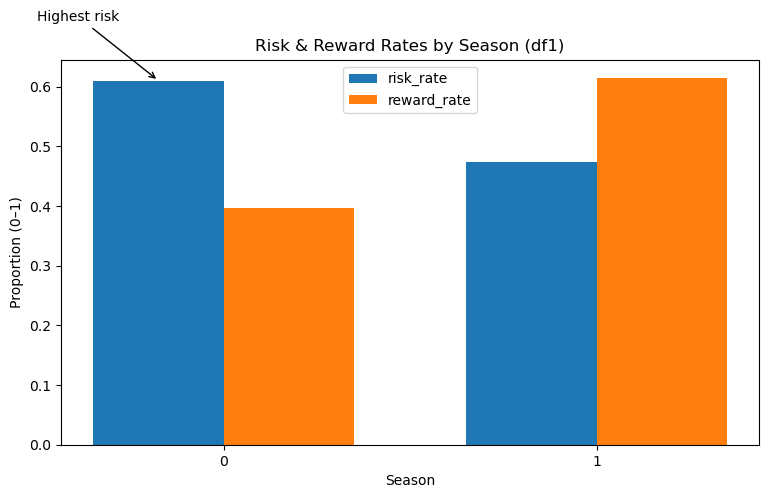

<ipython-input-2-b2294b3e940e>:126: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot(data, labels=order, showmeans=True, patch_artist=True)


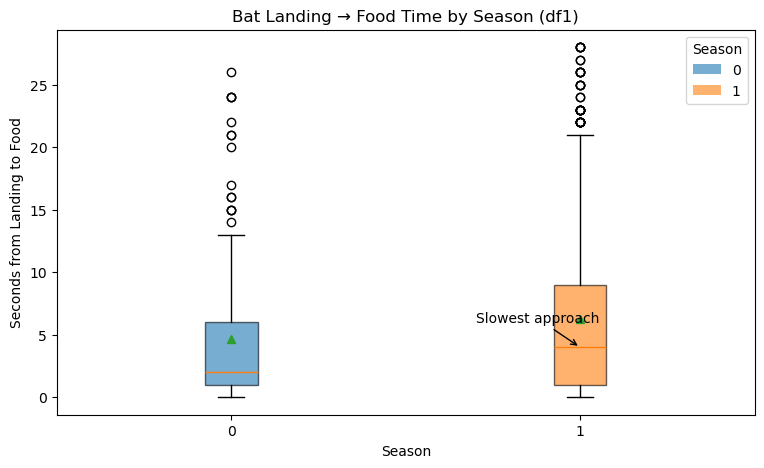

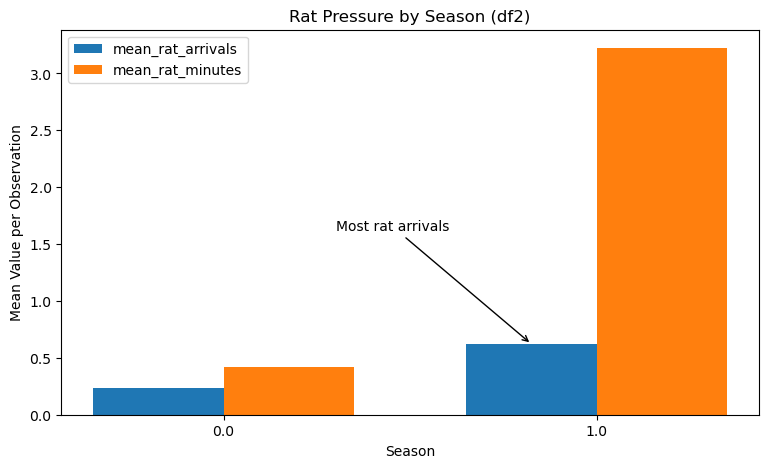

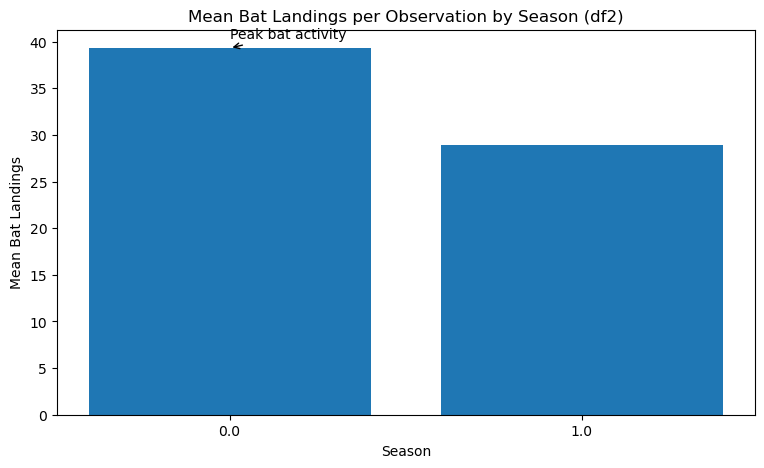

In [ ]:
# convert some columns to numeric
for c in ['risk','reward','bat_landing_to_food','seconds_after_rat_arrival']:
    if c in df1.columns:
        df1[c] = pd.to_numeric(df1[c], errors='coerce')

for c in ['rat_arrival_number','rat_minutes','bat_landing_number','food_availability','hours_after_sunset']:
    if c in df2.columns:
        df2[c] = pd.to_numeric(df2[c], errors='coerce')

# normalise month labels
if 'month' in df1.columns:
    df1['month'] = df1['month'].astype(str).str.strip()
if 'month' in df2.columns:
    df2['month'] = df2['month'].astype(str).str.strip()

# map month to season using df1
if {'month','season'}.issubset(df1.columns):
    month_season_map = (
        df1.groupby(['month','season'])
           .size()
           .reset_index(name='n')
           .sort_values(['month','n'], ascending=[True, False])
           .drop_duplicates('month')[['month','season']]
           .set_index('month')['season']
           .to_dict()
    )
else:
    month_season_map = {}

# assign season to df2 if missing
if 'season' not in df2.columns:
    df2['season'] = df2['month'].map(month_season_map)

# drop rows without season
df1_seasoned = df1.dropna(subset=['season']).copy() if 'season' in df1.columns else df1.copy()
df2_seasoned = df2.dropna(subset=['season']).copy()

# set winter and spring labels
winter_label = 'winter'
spring_label = 'spring'

def get_mask(df, season_label):
    return df['season'].astype(str).str.lower() == season_label

# two-proportion z-test for risk
if 'risk' in df1_seasoned.columns:
    mask_w = get_mask(df1_seasoned, winter_label)
    mask_s = get_mask(df1_seasoned, spring_label)
    count = [
        pd.to_numeric(df1_seasoned.loc[mask_w, 'risk'], errors='coerce').fillna(0).round().sum(),
        pd.to_numeric(df1_seasoned.loc[mask_s, 'risk'], errors='coerce').fillna(0).round().sum()
    ]
    nobs = [mask_w.sum(), mask_s.sum()]
    if all(n > 0 for n in nobs):
        z_stat, p_val = proportions_ztest(count, nobs)
        print(f"\n[Risk] Two-proportion z-test Winter vs Spring:")
        print(f"  counts={count}, n={nobs}, z={z_stat:.3f}, p={p_val:.5f}")

# Welch t-test for time-to-food
if 'bat_landing_to_food' in df1_seasoned.columns:
    x_w = pd.to_numeric(df1_seasoned.loc[get_mask(df1_seasoned, winter_label), 'bat_landing_to_food'], errors='coerce').dropna()
    x_s = pd.to_numeric(df1_seasoned.loc[get_mask(df1_seasoned, spring_label), 'bat_landing_to_food'], errors='coerce').dropna()
    if len(x_w) > 1 and len(x_s) > 1:
        from scipy import stats
        t_stat, p_val = stats.ttest_ind(x_w, x_s, equal_var=False, nan_policy='omit')
        print(f"\n[Time-to-food] Welch t-test Winter vs Spring:")
        print(f"  n_w={len(x_w)}, n_s={len(x_s)}, t={t_stat:.3f}, p={p_val:.5f}")

# correlations between rats and bats
def season_corr(df, season_label, x_col, y_col):
    s = df.loc[get_mask(df, season_label), [x_col, y_col]].apply(pd.to_numeric, errors='coerce').dropna()
    if len(s) < 3:
        return np.nan, np.nan
    from scipy import stats
    r, p = stats.pearsonr(s[x_col], s[y_col])
    return r, p

if {'rat_arrival_number','bat_landing_number'}.issubset(df2_seasoned.columns):
    for label in [winter_label, spring_label]:
        r, p = season_corr(df2_seasoned, label, 'rat_arrival_number', 'bat_landing_number')
        print(f"\n[Corr] {label.title()}: rat_arrival_number vs bat_landing_number -> r={r if not np.isnan(r) else 'NA'} p={p if not np.isnan(p) else 'NA'}")

# plots: risk/reward, time-to-food, rat arrivals, bat landings
if {'risk','reward','season'}.issubset(df1_seasoned.columns):
    # simple two-bar table by season using loops
    rates_dict = {}
    for i in range(len(df1_seasoned)):
        s = str(df1_seasoned.iloc[i]['season'])
        if s not in rates_dict:
            rates_dict[s] = {'risk_sum':0.0,'risk_cnt':0,'reward_sum':0.0,'reward_cnt':0}
        rv = pd.to_numeric(df1_seasoned.iloc[i]['risk'], errors='coerce')
        rw = pd.to_numeric(df1_seasoned.iloc[i]['reward'], errors='coerce')
        if pd.notna(rv):
            rates_dict[s]['risk_sum'] += float(rv); rates_dict[s]['risk_cnt'] += 1
        if pd.notna(rw):
            rates_dict[s]['reward_sum'] += float(rw); rates_dict[s]['reward_cnt'] += 1
    seasons_sorted = sorted(rates_dict.keys())
    risk_vals = [(rates_dict[s]['risk_sum']/rates_dict[s]['risk_cnt']) if rates_dict[s]['risk_cnt']>0 else np.nan for s in seasons_sorted]
    reward_vals = [(rates_dict[s]['reward_sum']/rates_dict[s]['reward_cnt']) if rates_dict[s]['reward_cnt']>0 else np.nan for s in seasons_sorted]

    x = np.arange(len(seasons_sorted))
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,5))
    bars1 = ax.bar(x - width/2, risk_vals, width, label='risk_rate')
    bars2 = ax.bar(x + width/2, reward_vals, width, label='reward_rate')
    ax.set_xticks(x)
    ax.set_xticklabels(seasons_sorted)
    ax.set_ylabel('Proportion (0–1)')
    ax.set_xlabel('Season')
    ax.set_title('Risk & Reward Rates by Season (df1)')
    ax.legend()

    # annotation: highlight max risk
    max_idx = int(np.nanargmax(risk_vals))
    ax.annotate('Highest risk', 
                xy=(x[max_idx]-width/2, risk_vals[max_idx]), 
                xytext=(x[max_idx]-0.5, risk_vals[max_idx]+0.1),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()

if {'bat_landing_to_food','season'}.issubset(df1_seasoned.columns):
    order = sorted(df1_seasoned['season'].dropna().astype(str).unique())
    data = [pd.to_numeric(df1_seasoned.loc[df1_seasoned['season'].astype(str)==s, 'bat_landing_to_food'], errors='coerce').dropna() for s in order]
    fig = plt.figure(figsize=(9,5))
    bp = plt.boxplot(data, labels=order, showmeans=True, patch_artist=True)
    palette = plt.cm.tab10.colors
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(palette[i % len(palette)]); patch.set_alpha(0.6)
    handles = [mpatches.Patch(facecolor=palette[i % len(palette)], alpha=0.6, label=order[i]) for i in range(len(order))]
    plt.legend(handles=handles, title='Season', loc='best')
    plt.title('Bat Landing → Food Time by Season (df1)')
    plt.ylabel('Seconds from Landing to Food')
    plt.xlabel('Season')

    # annotation: mark slowest median
    medians = [line.get_ydata()[0] for line in bp['medians']]
    slowest_idx = int(np.nanargmax(medians))
    plt.annotate('Slowest approach', 
                 xy=(slowest_idx+1, medians[slowest_idx]), 
                 xytext=(slowest_idx+0.7, medians[slowest_idx]+2),
                 arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()

if {'rat_arrival_number','rat_minutes','season'}.issubset(df2_seasoned.columns):
    # compute simple means via loops
    agg = {}
    for i in range(len(df2_seasoned)):
        s = str(df2_seasoned.iloc[i]['season'])
        if s not in agg:
            agg[s] = {'arr_sum':0.0,'arr_cnt':0,'min_sum':0.0,'min_cnt':0}
        ra = pd.to_numeric(df2_seasoned.iloc[i]['rat_arrival_number'], errors='coerce')
        rm = pd.to_numeric(df2_seasoned.iloc[i]['rat_minutes'], errors='coerce')
        if pd.notna(ra): agg[s]['arr_sum'] += float(ra); agg[s]['arr_cnt'] += 1
        if pd.notna(rm): agg[s]['min_sum'] += float(rm); agg[s]['min_cnt'] += 1
    seasons_sorted = sorted(agg.keys())
    mean_arrivals = [(agg[s]['arr_sum']/agg[s]['arr_cnt']) if agg[s]['arr_cnt']>0 else np.nan for s in seasons_sorted]
    mean_minutes  = [(agg[s]['min_sum']/agg[s]['min_cnt']) if agg[s]['min_cnt']>0 else np.nan for s in seasons_sorted]

    x = np.arange(len(seasons_sorted))
    width = 0.35
    fig, ax = plt.subplots(figsize=(9,5))
    ax.bar(x - width/2, mean_arrivals, width, label='mean_rat_arrivals')
    ax.bar(x + width/2, mean_minutes,  width, label='mean_rat_minutes')
    ax.set_xticks(x)
    ax.set_xticklabels(seasons_sorted)
    ax.set_ylabel('Mean Value per Observation')
    ax.set_xlabel('Season')
    ax.set_title('Rat Pressure by Season (df2)')
    ax.legend()

    # annotation: highlight max arrivals
    max_idx = int(np.nanargmax(mean_arrivals))
    ax.annotate('Most rat arrivals',
                xy=(x[max_idx]-width/2, mean_arrivals[max_idx]),
                xytext=(x[max_idx]-0.7, mean_arrivals[max_idx]+1),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()

if {'bat_landing_number','season'}.issubset(df2_seasoned.columns):
    # compute mean bat landings via loops
    agg = {}
    for i in range(len(df2_seasoned)):
        s = str(df2_seasoned.iloc[i]['season'])
        if s not in agg: agg[s] = {'sum':0.0,'cnt':0}
        v = pd.to_numeric(df2_seasoned.iloc[i]['bat_landing_number'], errors='coerce')
        if pd.notna(v): agg[s]['sum'] += float(v); agg[s]['cnt'] += 1
    seasons_sorted = sorted(agg.keys())
    means = [(agg[s]['sum']/agg[s]['cnt']) if agg[s]['cnt']>0 else np.nan for s in seasons_sorted]

    fig, ax = plt.subplots(figsize=(9,5))
    bars = ax.bar(seasons_sorted, means)
    ax.set_ylabel('Mean Bat Landings')
    ax.set_xlabel('Season')
    ax.set_title('Mean Bat Landings per Observation by Season (df2)')

    # annotation: highlight max
    max_idx = int(np.nanargmax(means))
    ax.annotate('Peak bat activity',
                xy=(max_idx, means[max_idx]),
                xytext=(max_idx, means[max_idx]+1),
                arrowprops=dict(facecolor='black', arrowstyle='->'))
    plt.show()